<a href="https://colab.research.google.com/github/LiQuinChing/DL-ReinforcementLearningPart2/blob/main/LunarLander_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup dependencies

In [32]:
pip uninstall -y gym gymnasium pygame box2d-py Box2D


In [33]:
pip install gymnasium==0.29.1 Box2D==2.3.10 pygame==2.5.2 torch==2.2.2

  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached Box2D-2.3.10-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (573 bytes)
  Using cached pygame-2.5.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached torch-2.2.2-cp312-cp312-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.met

In [1]:
import math, random, collections, time, os
from collections import deque
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# For reproducibility
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

Using device: cpu


Environment

In [2]:
# Gym 0.26 API: env.reset() -> (obs, info), env.step(a) -> (obs, reward, terminated, truncated, info)
ENV_ID = "LunarLander-v2"
env = gym.make(ENV_ID)    # Discrete action space: 4 actions
obs_dim = env.observation_space.shape[0]   # 8
n_actions = env.action_space.n             # 4
print("obs_dim =", obs_dim, "| n_actions =", n_actions)

obs_dim = 8 | n_actions = 4


Model (Q-network)

In [3]:
class QNet(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, n_actions)
        )
    def forward(self, x):
        return self.net(x)

Replay Buffer

In [4]:
class ReplayBuffer:
    def __init__(self, capacity=200_000):
        self.buf = deque(maxlen=capacity)
    def push(self, s, a, r, s1, done):
        self.buf.append((s, a, r, s1, done))
    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s, a, r, s1, d = map(np.array, zip(*batch))
        return (
            torch.tensor(s, dtype=torch.float32, device=DEVICE),
            torch.tensor(a, dtype=torch.long, device=DEVICE).unsqueeze(1),
            torch.tensor(r, dtype=torch.float32, device=DEVICE).unsqueeze(1),
            torch.tensor(s1, dtype=torch.float32, device=DEVICE),
            torch.tensor(d, dtype=torch.float32, device=DEVICE).unsqueeze(1),
        )
    def __len__(self):
        return len(self.buf)

DQN Agent (configurable)

In [5]:
class DQNAgent:
    def __init__(
        self,
        obs_dim,
        n_actions,
        gamma=0.99,
        lr=1e-3,
        batch_size=128,
        buffer_capacity=200_000,
        start_learning=10_000,
        train_freq=1,        # optimize every N env steps
        target_update=1000,  # hard copy every N optim steps (if use_target=True)
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay_steps=300_000,
        use_replay=True,
        use_target=True,
        verbose=True,
        seed=0
    ):
        set_seed(seed)
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.batch_size = batch_size
        self.start_learning = start_learning
        self.train_freq = train_freq
        self.use_replay = use_replay
        self.use_target = use_target
        self.target_update = target_update

        self.online = QNet(obs_dim, n_actions).to(DEVICE)
        self.target = QNet(obs_dim, n_actions).to(DEVICE)
        self.target.load_state_dict(self.online.state_dict())
        self.optimizer = optim.Adam(self.online.parameters(), lr=lr)
        self.loss_fn = nn.SmoothL1Loss()

        self.buffer = ReplayBuffer(buffer_capacity) if use_replay else None
        self.total_steps = 0
        self.optim_steps = 0
        self.verbose = verbose

        # Epsilon schedule (linear decay)
        self.eps_start = epsilon_start
        self.eps_end = epsilon_end
        self.eps_decay_steps = epsilon_decay_steps

    def epsilon(self):
        # linear decay from start to end over epsilon_decay_steps
        frac = min(1.0, self.total_steps / float(self.eps_decay_steps))
        return self.eps_start + frac * (self.eps_end - self.eps_start)

    @torch.no_grad()
    def act(self, state):
        eps = self.epsilon()
        if random.random() < eps:
            return random.randrange(self.n_actions), eps
        s_t = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        q = self.online(s_t)
        a = int(torch.argmax(q, dim=1).item())
        return a, eps

    def push_transition(self, s, a, r, s1, done):
        if self.use_replay:
            self.buffer.push(s, a, r, s1, done)

    def _compute_td_target(self, s1, r, done):
        with torch.no_grad():
            if self.use_target:
                q_next = self.target(s1).max(dim=1, keepdim=True)[0]
            else:
                q_next = self.online(s1).max(dim=1, keepdim=True)[0]
            return r + self.gamma * (1.0 - done) * q_next

    def optimize(self):
        if self.use_replay:
            if len(self.buffer) < self.start_learning:
                return None
            s, a, r, s1, d = self.buffer.sample(self.batch_size)
        else:
            # If not using replay, we need to have stashed the last transition (handled in train loop)
            return None

        q_pred = self.online(s).gather(1, a)           # [B,1]
        q_tgt  = self._compute_td_target(s1, r, d)     # [B,1]
        loss = self.loss_fn(q_pred, q_tgt)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.online.parameters(), 10.0)
        self.optimizer.step()
        self.optim_steps += 1

        # Hard update target
        if self.use_target and (self.optim_steps % self.target_update == 0):
            self.target.load_state_dict(self.online.state_dict())

        return float(loss.item())

Train and Evaluate

In [6]:
def train_agent(
    agent,
    env_id=ENV_ID,
    episodes=800,
    max_steps=1000,
    eval_every=100,
):
    rewards = []
    epsilons = []
    losses = []

    env = gym.make(env_id)
    start_time = time.time()

    for ep in range(1, episodes+1):
        state, _ = env.reset(seed=None)
        ep_reward = 0.0

        for t in range(max_steps):
            action, eps = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.push_transition(state, action, reward, next_state, float(done))

            # optimize (if using replay) at specified frequency
            agent.total_steps += 1
            if (agent.total_steps % agent.train_freq) == 0:
                loss = agent.optimize()
                if loss is not None:
                    losses.append(loss)

            ep_reward += reward
            state = next_state
            if done:
                break

        rewards.append(ep_reward)
        epsilons.append(agent.epsilon())

        if agent.verbose and (ep % 50 == 0 or ep == 1):
            avg50 = np.mean(rewards[-50:]) if len(rewards) >= 50 else np.mean(rewards)
            print(f"[{ep:4d}/{episodes}]  R_ep={ep_reward:7.2f} | avg(50)={avg50:7.2f} | eps={epsilons[-1]:.3f} | steps={agent.total_steps:,}")

        # quick evaluation (greedy)
        if (eval_every is not None) and (ep % eval_every == 0):
            avg_eval = evaluate(agent, n_episodes=10)
            print(f"  -> Eval avg reward over 10 episodes: {avg_eval:.2f}")

    elapsed = time.time() - start_time
    env.close()
    return {
        "rewards": rewards,
        "epsilons": epsilons,
        "losses": losses,
        "elapsed_sec": elapsed
    }

@torch.no_grad()
def evaluate(agent, n_episodes=10, render=False):
    env = gym.make(ENV_ID)
    total = 0.0
    for _ in range(n_episodes):
        state, _ = env.reset()
        ep_r = 0.0
        for _ in range(1000):
            # Greedy action (epsilon=0)
            s_t = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            a = int(torch.argmax(agent.online(s_t), dim=1).item())
            state, r, term, trunc, _ = env.step(a)
            ep_r += r
            if render:
                env.render()
            if term or trunc:
                break
        total += ep_r
    env.close()
    return total / n_episodes

Run: WITH replay + target

In [7]:
agent_replay_target = DQNAgent(
    obs_dim=obs_dim,
    n_actions=n_actions,
    gamma=0.99,
    lr=1e-3,
    batch_size=128,
    buffer_capacity=200_000,
    start_learning=10_000,
    train_freq=1,
    target_update=1_000,     # requirement: update every 1000 steps
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay_steps=300_000,
    use_replay=True,         # ON
    use_target=True,         # ON
    verbose=True,
    seed=0
)

hist_with = train_agent(agent_replay_target, episodes=800, max_steps=1000, eval_every=200)
eval_with = evaluate(agent_replay_target, n_episodes=10)
print(f"\nWITH replay+target  | Final eval avg reward (10 eps): {eval_with:.2f}\n")

# =========================
# 7) Run: WITHOUT replay + target (baseline)
#    (This is intentionally weak/unstable; it's for comparison.)
# =========================
agent_vanilla = DQNAgent(
    obs_dim=obs_dim,
    n_actions=n_actions,
    gamma=0.99,
    lr=1e-3,
    batch_size=128,
    # buffer won't be used when use_replay=False
    start_learning=0,         # not used
    train_freq=1,
    target_update=1_000,      # won't matter when use_target=False
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay_steps=300_000,
    use_replay=False,         # OFF
    use_target=False,         # OFF
    verbose=True,
    seed=1
)

hist_without = train_agent(agent_vanilla, episodes=400, max_steps=1000, eval_every=None)
eval_without = evaluate(agent_vanilla, n_episodes=10)
print(f"\nWITHOUT replay/target | Final eval avg reward (10 eps): {eval_without:.2f}\n")

[   1/800]  R_ep=-145.45 | avg(50)=-145.45 | eps=1.000 | steps=63
[  50/800]  R_ep=-112.32 | avg(50)=-177.75 | eps=0.986 | steps=4,525
[ 100/800]  R_ep=-249.83 | avg(50)=-165.13 | eps=0.971 | steps=9,084
[ 150/800]  R_ep= -74.70 | avg(50)=-154.58 | eps=0.956 | steps=13,772
[ 200/800]  R_ep=-176.71 | avg(50)=-132.13 | eps=0.941 | steps=18,693
  -> Eval avg reward over 10 episodes: -137.21
[ 250/800]  R_ep=-137.92 | avg(50)=-121.50 | eps=0.927 | steps=23,191
[ 300/800]  R_ep=-105.32 | avg(50)=-145.24 | eps=0.912 | steps=27,880
[ 350/800]  R_ep= -91.20 | avg(50)=-130.93 | eps=0.898 | steps=32,352
[ 400/800]  R_ep=-104.70 | avg(50)=-121.48 | eps=0.882 | steps=37,159
  -> Eval avg reward over 10 episodes: -66.72
[ 450/800]  R_ep=-150.05 | avg(50)=-105.43 | eps=0.869 | steps=41,494
[ 500/800]  R_ep= -87.27 | avg(50)=-106.80 | eps=0.854 | steps=46,180
[ 550/800]  R_ep= -69.89 | avg(50)= -96.75 | eps=0.839 | steps=50,926
[ 600/800]  R_ep= -85.41 | avg(50)= -94.33 | eps=0.824 | steps=55,611
  -

Plots

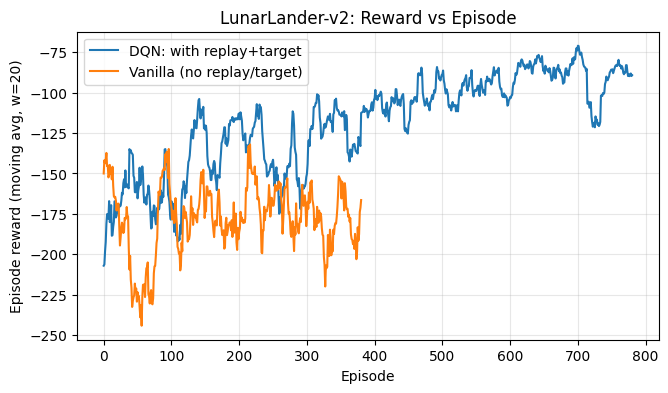

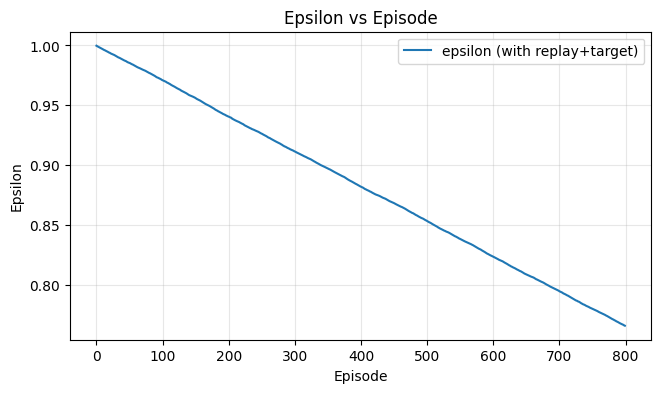

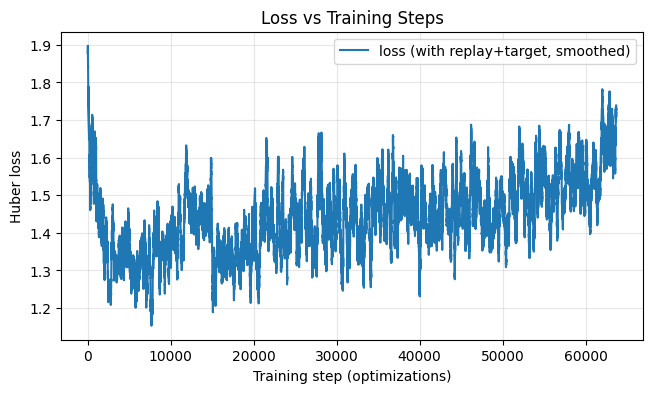

Elapsed (with replay+target): 457.1s
Elapsed (without replay/target): 3.6s
Eval avg reward WITH replay+target:    -22.01
Eval avg reward WITHOUT replay/target: -742.92


In [8]:
def moving_avg(x, w=20):
    if len(x) < w:
        return np.array(x, dtype=float)
    return np.convolve(x, np.ones(w)/w, mode="valid")

plt.figure(figsize=(7.5,4))
plt.plot(moving_avg(hist_with["rewards"], 20), label="DQN: with replay+target")
plt.plot(moving_avg(hist_without["rewards"], 20), label="Vanilla (no replay/target)")
plt.xlabel("Episode")
plt.ylabel("Episode reward (moving avg, w=20)")
plt.title("LunarLander-v2: Reward vs Episode")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7.5,4))
plt.plot(hist_with["epsilons"], label="epsilon (with replay+target)")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon vs Episode")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

if len(hist_with["losses"]) > 0:
    plt.figure(figsize=(7.5,4))
    plt.plot(moving_avg(hist_with["losses"], 200), label="loss (with replay+target, smoothed)")
    plt.xlabel("Training step (optimizations)")
    plt.ylabel("Huber loss")
    plt.title("Loss vs Training Steps")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

print("Elapsed (with replay+target):", f"{hist_with['elapsed_sec']:.1f}s")
print("Elapsed (without replay/target):", f"{hist_without['elapsed_sec']:.1f}s")
print(f"Eval avg reward WITH replay+target:    {eval_with:.2f}")
print(f"Eval avg reward WITHOUT replay/target: {eval_without:.2f}")